In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import List
from collections import Counter
import logging
import seaborn as sns

In [3]:
enb = pd.read_parquet("../data/curated/enb_books.parquet")

In [4]:
udc_94_mask = enb["udc"].str.split("; ").apply(lambda x: any([c == "94" for c in x]) if type(x) == list else False)

In [5]:
df = enb[udc_94_mask].query("is_fiction == False & chronological_keyword.notna()")

In [6]:
# Configure logging
logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s')

def parse_chronological_keywords(keyword_str: str) -> List[range]:
    """
    Parses a string of chronological keywords and converts them into a list of range objects.
    Handles AD and BC centuries, half-centuries (pools), decade ranges, specific year ranges,
    and multiple-century ranges.
    
    Args:
        keyword_str (str): The input string containing chronological keywords separated by semicolons.
    
    Returns:
        List[range]: A list of range objects representing the extracted year ranges.
    """
    ranges = []
    # Split the input string by semicolon and strip whitespace
    parts = [part.strip() for part in keyword_str.split(';')]

    for part in parts:
        original_part = part  # Keep the original part for logging
        is_bc = False
        # Check if the part indicates BC (eKr)
        if 'eKr' in part or 'EKr' in part or 'ekr' in part:
            is_bc = True
            # Remove the 'eKr' suffix for easier parsing
            part = re.sub(r'\s*eKr$', '', part, flags=re.IGNORECASE).strip()

        # 1. Century with Pool (Half-Century)
        m = re.match(r'^(\d+)\.\s*sajandi\s+(\d)\.\s*pool$', part, re.IGNORECASE)
        if m:
            century = int(m.group(1))
            pool = int(m.group(2))
            if is_bc:
                start_year = -century * 100
                if pool == 1:
                    end_year = -(century * 100 - 50)
                elif pool == 2:
                    start_year = -(century * 100 - 50) + 1
                    end_year = -(century * 100 - 1)
                else:
                    logging.warning(f"Invalid pool number in: '{original_part}'")
                    continue
            else:
                start_year = (century - 1) * 100 + 1
                if pool == 1:
                    end_year = (century - 1) * 100 + 50
                elif pool == 2:
                    start_year = (century - 1) * 100 + 51
                    end_year = century * 100
                else:
                    logging.warning(f"Invalid pool number in: '{original_part}'")
                    continue
            ranges.append(range(start_year, end_year + 1))
            continue

        # 2. Single Century
        m = re.match(r'^(\d+)\.\s*sajand$', part, re.IGNORECASE)
        if m:
            century = int(m.group(1))
            if is_bc:
                start_year = -century * 100
                end_year = -(century - 1) * 100 + 1
            else:
                start_year = (century - 1) * 100 + 1
                end_year = century * 100
            ranges.append(range(start_year, end_year + 1))
            continue

        # 3. Multiple-Century Range
        m = re.match(r'^(\d+)\.-\s*(\d+)\.\s*saj(?:and)?$', part, re.IGNORECASE)
        if m:
            start_century = int(m.group(1))
            end_century = int(m.group(2))
            if start_century > end_century:
                logging.warning(f"Start century {start_century} is after end century {end_century} in: '{original_part}'")
                continue
            if is_bc:
                start_year = -end_century * 100
                end_year = -(start_century - 1) * 100 + 1
            else:
                start_year = (start_century - 1) * 100 + 1
                end_year = end_century * 100
            ranges.append(range(start_year, end_year + 1))
            continue

        # 4. Decade (with or without hyphen)
        m = re.match(r'^(\d{3,4})-?ndad$', part, re.IGNORECASE)
        if m:
            decade_start = int(m.group(1))
            # Ensure the decade starts at a multiple of 10
            if decade_start % 10 != 0:
                logging.warning(f"Decade start year should be a multiple of 10 in: '{original_part}'")
                continue
            decade_end = decade_start + 10
            ranges.append(range(decade_start, decade_end))
            continue

        # 5. Specific Year Range
        m = re.match(r'^(\d{4})-(\d{4})$', part)
        if m:
            start = int(m.group(1))
            end = int(m.group(2))
            if start > end:
                logging.warning(f"Start year {start} is after end year {end} in: '{original_part}'")
                continue
            ranges.append(range(start, end + 1))
            continue

        # If none of the patterns matched, log a warning and skip
        logging.warning(f"Unrecognized format: '{original_part}'")
        continue

    return ranges

In [7]:
def count_years_in_ranges(ranges: List[range]) -> pd.DataFrame:
    """
    Counts the occurrences of each year across a list of range objects.

    Args:
        ranges (List[range]): A list of range objects representing year ranges.

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'year' and 'count',
                      where 'count' is the number of times the year appears in the ranges.
    """
    counter = Counter()
    for r in ranges:
        counter.update(r)

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    df.index.name = 'year'
    df = df.reset_index()

    # Sort by year
    df = df.sort_values('year').reset_index(drop=True)

    return df

In [8]:
def explode_keywords_with_weights(row):
    """
    Given a row with 'chronological_keyword' and 'publication_date_cleaned',
    parse the keywords into years, assign weights, and return a list of dictionaries.
    """
    publication_year = row['publication_date_cleaned']
    keyword_str = row['chronological_keyword']
    
    # Parse the keywords into ranges
    try:
        ranges = parse_chronological_keywords(keyword_str)
    except Exception as e:
        logging.warning(f"Error parsing keywords '{keyword_str}': {e}")
        return []
    
    # Extract all years from the ranges
    about_years = [year for r in ranges for year in r]
    num_years = len(about_years)
    
    if num_years == 0:
        return []
    
    # Assign weight to each year
    weight = 1 / num_years
    
    # Create list of dictionaries
    data = [{'publication_year': publication_year, 'about_year': year, 'weight': weight} for year in about_years]
    return data

In [9]:
# Apply the function to each row and explode the lists into separate rows
exploded_df = df.apply(explode_keywords_with_weights, axis=1).explode().dropna().reset_index(drop=True)
exploded_df = pd.DataFrame.from_records(exploded_df)

In [10]:
# Remove rows where 'about_year' is missing (if any)
exploded_df = exploded_df.dropna()

# Convert 'about_year' to integer
exploded_df['about_year'] = exploded_df['about_year'].astype(int)

# Reset index after explode
exploded_df = exploded_df.reset_index(drop=True)

# Display the exploded DataFrame
print("Exploded DataFrame:")
print(exploded_df.head())

Exploded DataFrame:
  publication_year  about_year  weight
0             2008        1980     0.1
1             2008        1981     0.1
2             2008        1982     0.1
3             2008        1983     0.1
4             2008        1984     0.1


In [11]:
def determine_decade(year: int) -> int:
    """
    Determines the starting year of the decade for a given year.
    
    Args:
        year (int): The year (negative for BC, positive for AD).
        
    Returns:
        int: The starting year of the decade.
    """
    if year < 0:
        # For BC years, e.g., -105 -> -110
        decade_start = (year // 10) * 10
        if year % 10 == 0:
            decade_start -= 10  # Adjust if exactly divisible by 10
    else:
        # For AD years, e.g., 1945 -> 1940
        decade_start = (year // 10) * 10
    return decade_start

In [12]:
# Group by 'publication_year' and 'about_year' and sum the weights
aggregated_df = exploded_df.groupby(['publication_year', 'about_year'])['weight'].sum().reset_index()
aggregated_df['publication_decade'] = aggregated_df['publication_year'].apply(determine_decade)
aggregated_df['about_decade'] = aggregated_df['about_year'].apply(determine_decade)

# Group by 'publication_decade' and 'about_decade' and compute the average weight
decadal_aggregated_df = aggregated_df.groupby(['publication_decade', 'about_decade'])['weight'].mean().reset_index()

# Display the decadal aggregated DataFrame
print("\nDecadal Aggregated DataFrame:")
print(decadal_aggregated_df.head())


Decadal Aggregated DataFrame:
   publication_decade  about_decade  weight
0                1560          1500    0.02
1                1560          1510    0.02
2                1560          1520    0.02
3                1560          1530    0.02
4                1560          1540    0.02


In [13]:
### DETERMINE PLOT X AND Y LIMITS HERE
decadal_aggregated_df = decadal_aggregated_df.query(
    "about_decade <= 2000 & about_decade >= 1500 & about_decade < publication_decade & publication_decade >= 1900"
    )

In [14]:
# Pivot the decadal aggregated DataFrame
decadal_heatmap_data = decadal_aggregated_df.pivot_table(
    index='publication_decade',
    columns='about_decade',
    values='weight',
    aggfunc='mean',
    fill_value=0
)

# Display the pivoted decadal heatmap DataFrame
print("\nPivoted Decadal Heatmap DataFrame:")
print(decadal_heatmap_data.head())


Pivoted Decadal Heatmap DataFrame:
about_decade            1500      1510      1520      1530      1540  \
publication_decade                                                     
1900                0.015986  0.016000  0.016000  0.016000  0.016000   
1910                0.013793  0.014000  0.014000  0.014000  0.014000   
1920                0.013500  0.014167  0.014167  0.014167  0.014167   
1930                0.009103  0.009375  0.009375  0.009375  0.009375   
1940                0.002500  0.002500  0.002500  0.002500  0.002500   

about_decade            1550      1560      1570      1580      1590  ...  \
publication_decade                                                    ...   
1900                0.012927  0.012500  0.012500  0.012500  0.012500  ...   
1910                0.017692  0.018000  0.018000  0.018000  0.018000  ...   
1920                0.020417  0.022500  0.022500  0.022500  0.022500  ...   
1930                0.016552  0.017083  0.017083  0.017083  0.017083  ... 

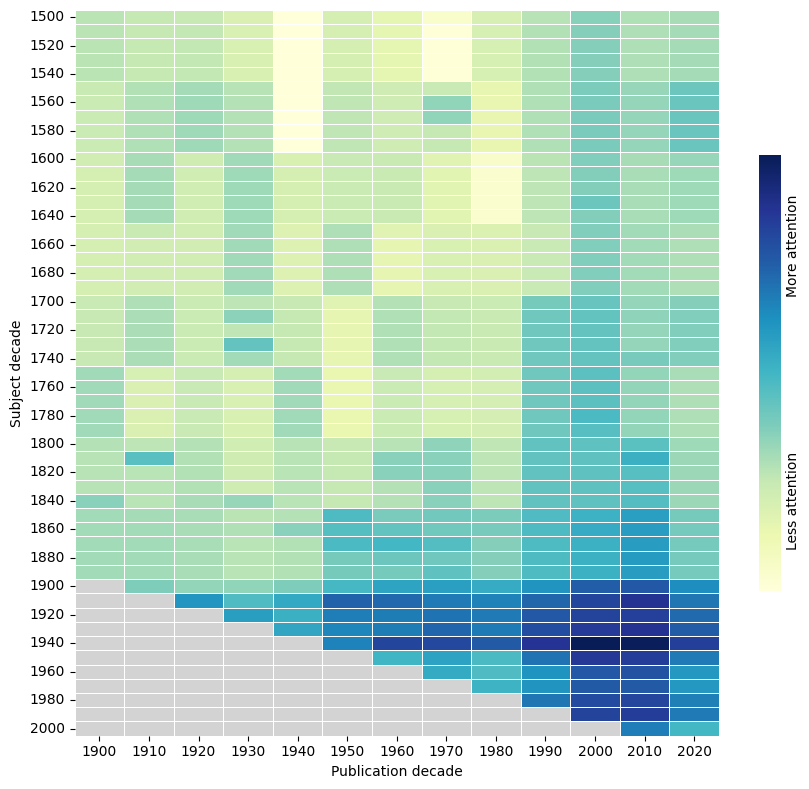

In [22]:
from matplotlib.colors import LogNorm

# Transpose the heatmap data to switch axes
transposed_heatmap_data = decadal_heatmap_data.transpose()

# Calculate the minimum positive value for LogNorm to avoid log(0)
min_positive = transposed_heatmap_data[transposed_heatmap_data > 0].min().min()

# Calculate the overall maximum value for vmax
max_value = transposed_heatmap_data.max().max()

# Create a mask for zero or negative values
mask = transposed_heatmap_data <= 0

# Replace zero or negative values with NaN to avoid plotting them
transposed_heatmap_data_masked = transposed_heatmap_data.mask(mask)

# Create the Heatmap with Logarithmic Scale
plt.figure(figsize=(9,8))
sns.heatmap(
    transposed_heatmap_data_masked,
    cmap='YlGnBu',
    linewidths=.5,
    annot=False,
    norm=LogNorm(vmin=min_positive, vmax=max_value),
    #cbar=None,
    cbar_kws={'shrink': 0.6, 'ticks': [1.1, 0.02]}
)

ax = plt.gca()
ax.set_facecolor("lightgrey")
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(axis='both', which='both', length=0)
cbar.set_ticklabels(["More attention", "Less attention"], rotation=90)

# Customize the plot labels and title
plt.xlabel('Publication decade')
plt.ylabel('Subject decade')

# Adjust layout for better fit
plt.tight_layout()
plt.savefig("../reports/plots/figure6_historiography_heatmap.png", dpi=300, bbox_inches="tight")

# Display the heatmap
plt.show()